**Brian Blaylock**  
**March 27, 2018**

# Explore Contingency Table and Fractions Skill Score
## Single Day

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os
from matplotlib.path import Path

import matplotlib as mpl
#mpl.rcParams['figure.figsize'] = [15,15]
mpl.rcParams['figure.titlesize'] = 15
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['axes.titlesize'] = 15
mpl.rcParams['lines.linewidth'] = 1.8
mpl.rcParams['grid.linewidth'] = .25
mpl.rcParams['figure.subplot.wspace'] = 0.15
mpl.rcParams['figure.subplot.hspace'] = 0.15
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['legend.framealpha'] = .75
mpl.rcParams['legend.loc'] = 'best'
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.dpi'] = 100

SAVEDIR = '/uufs/chpc.utah.edu/common/home/u0553130/public_html/PhD/HRRR_GOES/GLM_hit_rate/'
if not os.path.exists(SAVEDIR):
    os.makedirs(SAVEDIR)

import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3')
from BB_maps.my_basemap import draw_HRRR_map, draw_centermap
from BB_HRRR.HRRR_Pando import get_hrrr_latlon, get_hrrr_variable
from BB_HRRR.GLM_and_HRRR.GLM_events_HRRR import get_GLM_HRRR_contingency_stats,\
                                                 hit_rate, \
                                                 false_alarm_ratio
from BB_HRRR.HRRR_paths import get_domains
from BB_GOES.get_GLM import get_GLM_file_nearesttime, accumulate_GLM_FAST

Create HRRR map.
Forecasts [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
Generate domains and masks.


In [2]:
m = draw_HRRR_map()

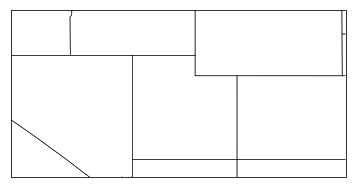

In [91]:
mUtah = draw_centermap('Utah', size=(4,8))
mUtah.drawstates()

In [4]:
Hlat, Hlon = get_hrrr_latlon(DICT=False)

In [5]:
domains = get_domains()

In [76]:
## Specify the valid Datetime of interest
#DATE = datetime(2018, 5, 14, 22) # Mallard Fire
#DATE = datetime(2018, 7, 5, 23)  # Lake Christine 1
DATE = datetime(2018, 7, 6, 0)    # Lake Christine 2
#DATE = datetime(2018, 7, 17, 6)  # July Storm
#DATE = datetime(2018, 7, 27, 0)  # Missing GLM data

#DATE = datetime(2018, 7, 6, 0) # Test July 1, 2019

In [77]:
# Rerun the entire calculation: 
# return table(a,b,c,d) and grids for Observed and Forecasted Binary.
table = get_GLM_HRRR_contingency_stats(DATE)

(1/7) Get GLM Events.
-->> Accumulate GLM FAST MP: 45.0%
Got 180 of 180 expected files.
Total Events: 3,812,139
(2/7) Get HRRR Data.
(3/7) Filter GLM.
(4/7) Put GLM on HRRR grid.
In-HRRR Events: 2,124,417
      2,124,417 events in HRRR
        147,023 events in West
        925,454 events in Central
      1,017,714 events in East
            184 events in Utah
(5/7) Bloat GLM data with spatial filter.
(6/7) Generate binary grids.
(7/7) Compute contingency table for each subdomain.
    Stats for HRRR
    Stats for West
    Stats for Central
    Stats for East
    Stats for Utah
(FIN)


In [70]:
a, b, c, d = np.array(table['table']['HRRR'])[:,14]
hit_rate(a, b, c, d), false_alarm_ratio(a, b, c, d)

(0.13430022514267762, 0.6248824819805704)

In [71]:
table.keys()

dict_keys(['Number Events', 'table', 'Observed Binary', 'Forecast Binary', 'Number GLM Files', 'Number Expected Files', 'DATETIME'])

/uufs/chpc.utah.edu/common/home/u0553130/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


Red contour is F01, Blue contour if F18


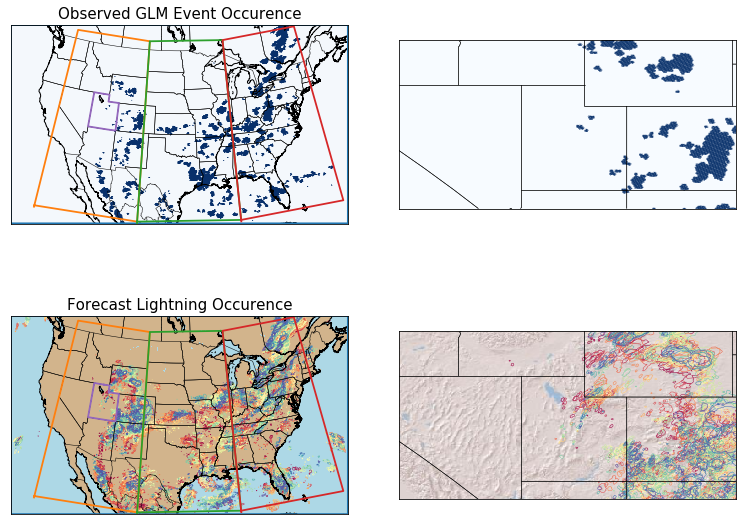

In [101]:
cmap = mpl.cm.get_cmap('Spectral')
rgba = cmap(np.linspace(0,1,18))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(13,10))

plt.sca(ax1)
plt.title('Observed GLM Event Occurence')
m.pcolormesh(Hlon, Hlat, table['Observed Binary'], latlon=True, cmap='Blues', alpha=.3)
m.drawlsmask(land_color='tan',ocean_color='lightblue',lakes=True)
for DOM in domains:
    m.plot(domains[DOM]['lon'], domains[DOM]['lat'], latlon=True) 
m.drawcoastlines()
m.drawstates()
m.drawcountries()

plt.sca(ax2)
mUtah.pcolormesh(Hlon, Hlat, table['Observed Binary'], latlon=True, cmap='Blues', alpha=.3)
mUtah.drawstates()

for i, F in enumerate(table['Forecast Binary']):
    plt.sca(ax3)
    m.contour(Hlon, Hlat, F, levels=1, colors=[rgba[i]], latlon=True, linewidths=.5)
    plt.sca(ax4)
    mUtah.contour(Hlon, Hlat, F, levels=1, colors=[rgba[i]], latlon=True, linewidths=.5)

plt.sca(ax3)
plt.title('Forecast Lightning Occurence')
m.drawlsmask(land_color='tan',ocean_color='lightblue',lakes=True)
for DOM in domains:
    m.plot(domains[DOM]['lon'], domains[DOM]['lat'], latlon=True) 
m.drawcoastlines()
m.drawstates()
m.drawcountries()

plt.sca(ax4)    
mUtah.arcgisimage(service='World_Shaded_Relief', verbose=False)
mUtah.drawstates()

print('Red contour is F01, Blue contour if F18')

# Single Datetime: Hit Rate/ False Alarm Ratio

In [73]:
def get_GLM_HRRR_stats_day(DATE, DOMAIN, verbose=True):
    DIR = '/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_HRRR/GLM_and_HRRR/HRRR_GLM_contingency_table'
    FILE = '/%s/%s_2018_m%02d_h%02d.csv' % (DOMAIN, DOMAIN, DATE.month, DATE.hour)

    data = np.genfromtxt(DIR+FILE, delimiter=',', names=True, dtype=None, encoding='UTF-8')
    # NOTE: Set encoding to 'UTF-8' so the date doesn't return as bytes

    if verbose:
        print(data.dtype.names)
    
    # Get the data from the line that cooresponds to the date requested
    line = data[DATE.day-1]

    # Double check that the line we got is the date requested
    if datetime.strptime(line[0], '%Y-%m-%d %H:%M:%S') != DATE:
        print('WARNING: Date of this line does not match the requested DATE')
        print('Grabbed date ', line[0])
    
    if verbose:
        #number of flashes
        num_flashes = int(line[1])
        print('Got {:,} events in {:} domain ({:} of {:} files).'.format(num_flashes, DOMAIN, line[2], line[3]))
    
    return line

def get_GLM_HRRR_FSS_day(DATE, DOMAIN, radius, verbose=True):
    DIR = '/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_HRRR/GLM_and_HRRR/HRRR_GLM_Fractions_Skill_Score_r%02d/' % radius
    FILE = '%s/%s_2018_m%02d_h%02d.csv' % (DOMAIN, DOMAIN, DATE.month, DATE.hour)

    data = np.genfromtxt(DIR+FILE, delimiter=',', names=True, dtype=None, encoding='UTF-8')
    # NOTE: Set encoding to 'UTF-8' so the date doesn't return as bytes

    if verbose:
        print(data.dtype.names)
    
    # Get the data from the line that cooresponds to the date requested
    line = data[DATE.day-1]

    # Double check that the line we got is the date requested
    if datetime.strptime(line[0], '%Y-%m-%d %H:%M:%S') != DATE:
        print('WARNING: Date of this line does not match the requested DATE')
        print('Grabbed date ', line[0])
    
    if verbose:
        #number of flashes
        num_flashes = int(line[1])
        print('Got {:,} events in {:} domain ({:} of {:} files).'.format(num_flashes, DOMAIN, line[2], line[3]))
    
    return line


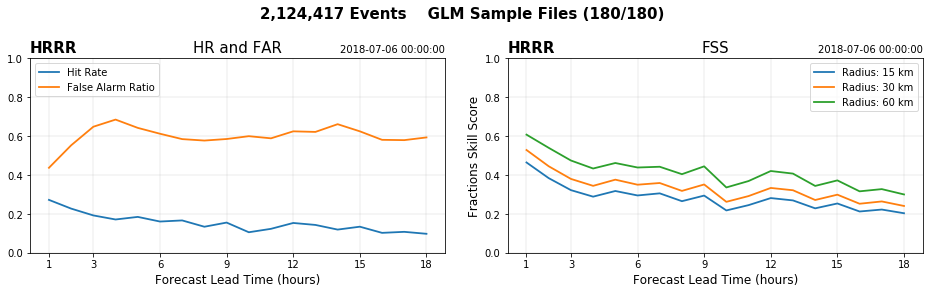

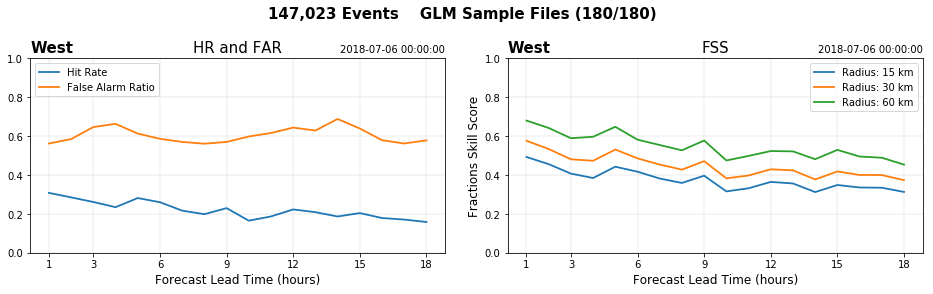

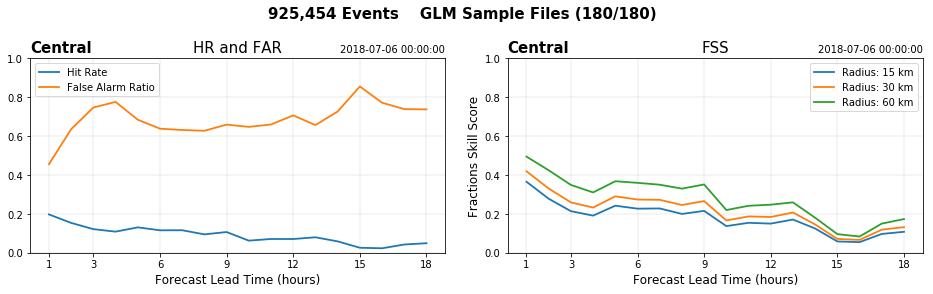

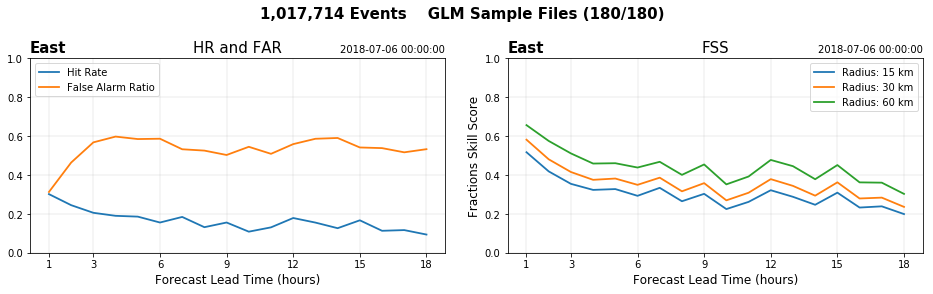

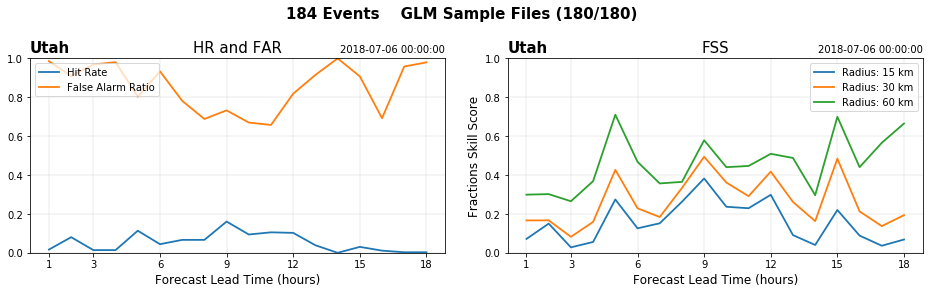

In [100]:
radii = [5, 10, 20] # For FSS scores files available


for DOMAIN in domains:
    line = get_GLM_HRRR_stats_day(DATE, DOMAIN, verbose=False)

    fix, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))

    events = int(line['GLM_Event_COUNT'])
    files = line['NUM_FILES']
    expected = line['EXPECTED_FILES']
    plt.suptitle('{:,} Events    GLM Sample Files ({:}/{:})'.format(events, files, expected))
    
    plt.sca(ax1)
    A = np.array([line['F%02d_A' % (i)] for i in range(1,19)])
    B = np.array([line['F%02d_B' % (i)] for i in range(1,19)])
    C = np.array([line['F%02d_C' % (i)] for i in range(1,19)])
    D = np.array([line['F%02d_D' % (i)] for i in range(1,19)])

    hitRate = hit_rate(A, B, C, D)
    falseAlarmRatio = false_alarm_ratio(A, B, C, D)

    plt.plot(range(1,19), hitRate, label='Hit Rate')
    plt.plot(range(1,19), falseAlarmRatio, label='False Alarm Ratio')
    plt.xlabel('Forecast Lead Time (hours)')
    plt.ylabel('')
    plt.ylim([0,1])
    plt.xticks([1,3,6,9,12,15,18], [1,3,6,9,12,15,18])
    
    plt.title(DOMAIN, loc='left', fontweight='semibold')
    plt.title("HR and FAR")
    plt.title(DATE, loc='right', fontsize=10)
    
    plt.grid()
    plt.legend(loc=2)
    
    plt.sca(ax2)
    FSS = [get_GLM_HRRR_FSS_day(DATE, DOMAIN, r, verbose=False) for r in radii]

    for fss, r in zip(FSS, radii):
        values = [fss['F%02d_FSS' % h] for h in range(1,19)]
        plt.plot(range(1,19), values, label='Radius: %s km' % (r*3))

    plt.xticks(range(1,19))

    plt.legend()
    plt.grid()

    plt.xlabel('Forecast Lead Time (hours)')
    plt.ylabel('Fractions Skill Score')
    plt.ylim([0,1])
    plt.xticks([1,3,6,9,12,15,18], [1,3,6,9,12,15,18])
    plt.title(DOMAIN, loc='left', fontweight='semibold')
    plt.title('FSS')
    plt.title(DATE, loc='right', fontsize=10)
    
    plt.subplots_adjust(top=0.8)
    SAVEDIR = '/uufs/chpc.utah.edu/common/home/u0553130/public_html/PhD/GLM_and_HRRR/stats_single_time/'
    if not os.path.exists(SAVEDIR):
            os.makedirs(SAVEDIR)
    plt.savefig(SAVEDIR+'%s_%s' % (DATE.strftime('%Y-%m-%d_%H%M'), DOMAIN))

# Percentage of Area with Forecasted LTNG and Observed GLM Events 

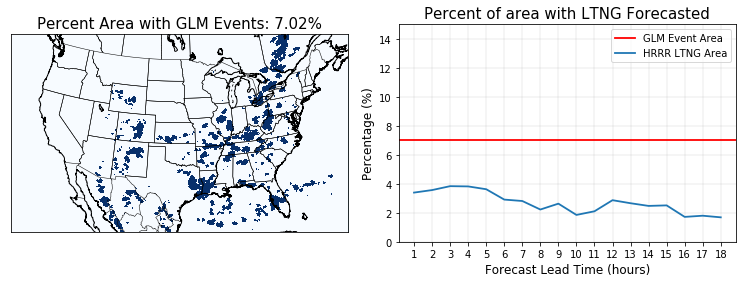

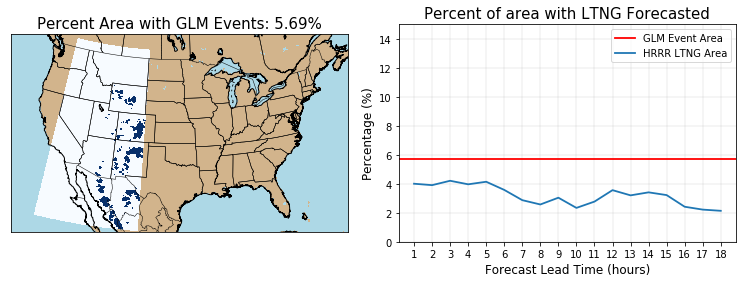

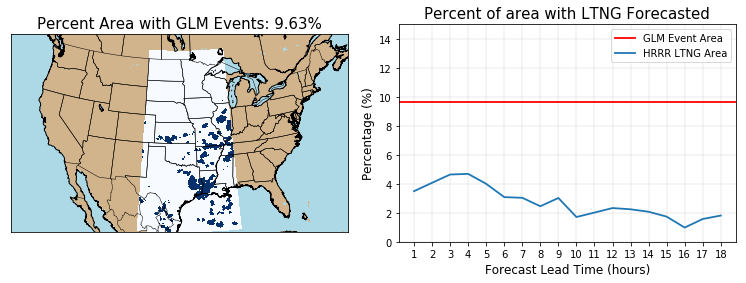

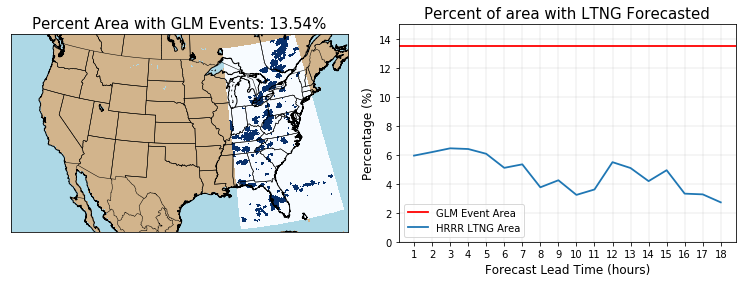

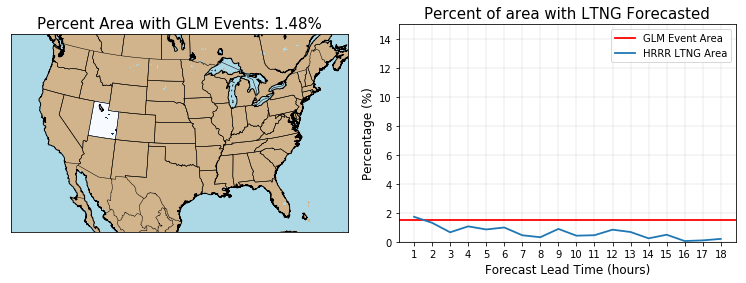

In [95]:
for DOMAIN in domains:
    total_DOMAIN_grid_points = np.sum(np.invert(domains[DOMAIN]['mask']))

    masked_array = np.ma.array(table['Observed Binary'], mask=domains[DOMAIN]['mask'])

    points_with_GLM= np.sum(masked_array)
    points_without_GLM = np.sum(np.invert(masked_array))
    
    percentage_with_GLM = points_with_GLM/total_DOMAIN_grid_points
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,4))
    plt.sca(ax1)
    plt.title('Percent Area with GLM Events: %.2f%%' % (percentage_with_GLM*100))
    m.pcolormesh(Hlon, Hlat, masked_array, latlon=True, cmap='Blues')
    m.drawlsmask(land_color='tan',ocean_color='lightblue',lakes=True)
    m.drawstates()
    m.drawcountries()
    m.drawcoastlines()
    
    plt.sca(ax2)
    LTNG_area = []
    for F in table['Forecast Binary']:
        masked_array = np.ma.array(F, mask=domains[DOMAIN]['mask'])
        points_with_LTNG= np.sum(masked_array)
        points_without_LTNG = np.sum(np.invert(masked_array))
        percentage_with_LTNG = points_with_LTNG/total_DOMAIN_grid_points
        LTNG_area.append(percentage_with_LTNG)
    
    plt.axhline(percentage_with_GLM*100, c='r', label='GLM Event Area')
    plt.plot(range(1,19), np.array(LTNG_area)*100, label='HRRR LTNG Area')
    plt.grid()
    plt.ylim([0,15])
    plt.xticks(range(1,19))
    plt.ylabel('Percentage (%)')
    plt.xlabel('Forecast Lead Time (hours)')
    plt.title('Percent of area with LTNG Forecasted')
    plt.legend()